In [24]:
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
import json
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'variant' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
  
from slab import *
from slab.dsfit import fithanger_new_withQc

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd
from numpy import pi, sqrt, array
from h5py import File

In [62]:
def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

def opt_read_pulse(t, cav_freq, Q, A, sig, tc, tb):
    #Same inputs as the erf_t function (Same units as t array-seconds) as well as properties of intended microwave cavity resonator: 
    #The cavity frequency cav_freq (Hz), the quality factor Q
    
    #Define range of frequencies centered at cavity frequency 
    kappa = cav_freq / Q 
    cav_freq = 0 #For simplicity this center frequency is moved to zero
    ifreq = np.fft.fftfreq(len(t), t[1] - t[0])
    freq = np.fft.fftshift(ifreq) #"sfft" denotes shifted spectrum to center at cav_freq
    
    #Define desired output shape
    desired_output = erf_t(A, sig, tc, tb, t)
    if (desired_output[0] != float(0)) & (desired_output[-1] != float(0)):
        print('Desired output pulse is too long for the given time range \nCheck Optimized Pulse for high frequency noise and/or wrapping problems')
    elif 2*sig+tc+2*tb > max(t):
        print('Desired output pulse is too long for the given time range \nCheck Optimized Pulse for high frequency noise and/or wrapping problems')   
    desired_output_ifft = fft.fft(desired_output,n_points*pad_factor)/n_points
    desired_output_sfft = fft.fftshift(desired_output_ifft) 

    #Define Possible Cavity Lorentzians based on Qubit State
    lorenz_c = cav_response_new([cav_freq,kappa],freq)
    lorenz_g = cav_response_new([cav_freq+0.2e6,Q],freq)
    lorenz_e = cav_response_new([cav_freq-0.2e6,Q],freq)
    lorenz= (lorenz_g*lorenz_e)
    
    #Select which lorentzian to use and find Optimized Input Pulse
    input_sfft = desired_output_sfft/lorenz_c

    output_sfft = input_sfft*lorenz_c
    output_fft = fft.ifftshift(output_sfft)
    output_pulse = fft.ifft(output_sfft)

    input_fft= fft.ifftshift(input_sfft)
    input_pulse = fft.ifft(input_fft)
    flip=input_pulse[::-1]

    opt_pulse = real(flip/abs(max(flip)))
    return desired_output, opt_pulse

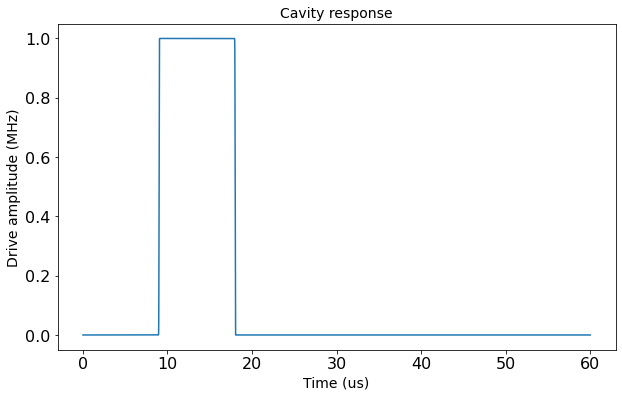

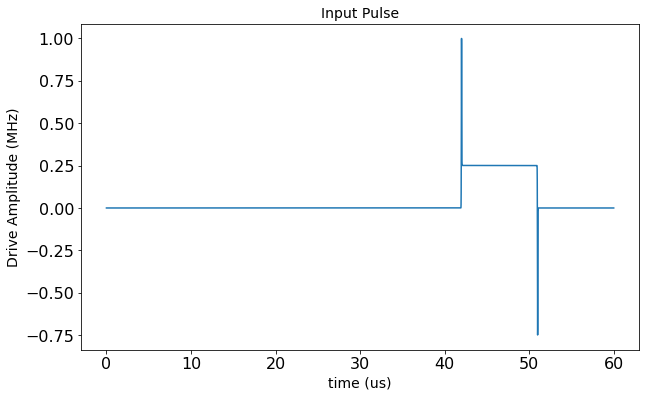

In [63]:
read_width = 3e-6 #readout length  in (seconds)
dt = 1e-9
n_points = int(read_width/dt)

pad_factor = 20
t = dt*np.arange(0, n_points*pad_factor)
ifreq = np.fft.fftfreq(n_points*pad_factor, dt)
freq = np.fft.fftshift(ifreq)

desired_output, opt_pulse = opt_read_pulse(t, 7.79e9, 8500, 1, 20e-9, 9000e-9, 9000e-9)


#Plot Desired Output
figure(figsize = (10, 6))
plot(t*1e6, desired_output)
xlabel('Time (us)', fontsize =14)
ylabel('Drive amplitude (MHz)', fontsize =14)
title('Cavity response', fontsize =14)


#Plot Generated Input Pulse
figure(figsize = (10,6))
plot(t*1.0e6,opt_pulse)
#axvline(t[int(19990/2)]*1e6)
xlabel("time (us)", fontsize = 14)
ylabel("Drive Amplitude (MHz)", fontsize = 14)
title('Input Pulse', fontsize = 14)
plt.show()

In [64]:
print(opt_pulse[int(19990/2)])
result1 = np.where(opt_pulse > 0.00001)
result2=np.where(opt_pulse < -0.00001)
#print(result)
#print(result1)
#print(result2)
#print(opt_pulse[1587-900:1587+100])
start_trim=result1[0][0]
end_trim=result2[0][len(result2[0])-2]
numb= end_trim - start_trim  
rem= numb % 4

print(start_trim, end_trim)
print(rem)

-5.391566640505994e-15
41904 51093
1


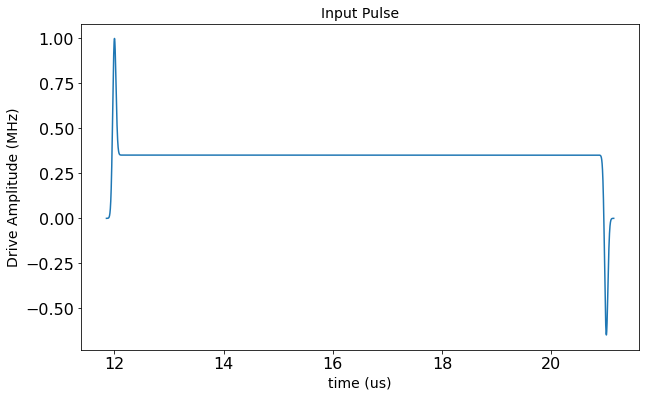

In [52]:
trim_opt_pulse = opt_pulse[start_trim:end_trim]
figure(figsize = (10,6))
plot(t[start_trim:end_trim]*1.0e6,trim_opt_pulse)
#axvline(t[int(19990/2)]*1e6)
xlabel("time (us)", fontsize = 14)
ylabel("Drive Amplitude (MHz)", fontsize = 14)
title('Input Pulse', fontsize = 14)
plt.show()

In [65]:
len(trim_opt_pulse)

9283

In [73]:
s = trim_opt_pulse[::3][:-3]

In [61]:
path = os.getcwd()
data_path = os.path.join(path, "../pulses/")
seq_data_file = os.path.join(data_path,
                             get_next_filename(data_path, 'readout_optimal_pulse', suffix='.h5'))
print(seq_data_file)
with File(seq_data_file, 'w') as f:
    f.create_dataset("I_wf", data=s)

C:\_Lib\python\slab\experiments\qm_opx_mm\jupyter_notebooks\../pulses/00017_readout_optimal_pulse.h5


In [74]:
len(s)

3060

In [75]:
3060/4

765.0

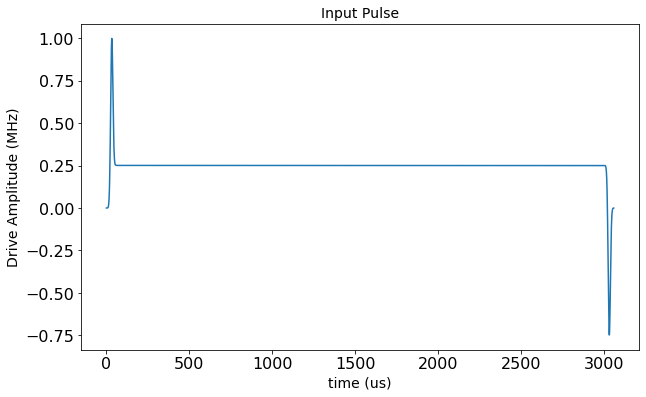

In [76]:
trim_opt_pulse = opt_pulse[start_trim:end_trim]
figure(figsize = (10,6))
plot(trim_opt_pulse[::3][:-3])
#axvline(t[int(19990/2)]*1e6)
xlabel("time (us)", fontsize = 14)
ylabel("Drive Amplitude (MHz)", fontsize = 14)
title('Input Pulse', fontsize = 14)
plt.show()